# Heat and Cluster Maps

```
Dustin Michels
November 2017
```

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

## Load / Prep Data

In [2]:
# This set the level of taxonomic analysis
TAXON_LVL = 3

# This runs code from load_data notebook, pulling its
# global vars and fcn declarations to this namespace
%run load_data.ipynb

In [3]:
# Load approporate DFs, using newly loaded vars/ fcns

go_df = get_top_n(full_go, by_col='read_percent', n=25)
go_df = rename_shorter(go_df)
go_df = truncate_names(go_df)

tax_df = get_top_n(full_tax, by_col='tax_percent', n=10)
tax_df = rename_shorter(tax_df)

## Make Heat Maps

### Define Functions

In [4]:
def make_heatmap(df, filename):
    """Make heatmap"""
    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(ax=ax, data=df)
    fig.autofmt_xdate(rotation=45)
    fig.savefig(
        f'{img_path}heat/{filename}.png',
        bbox_inches='tight', dpi=300)

In [5]:
def make_clustermap(df, filename):
    """Make clustermap"""
    
    ax = sns.clustermap(data=df)
    ax.savefig(
        f'{img_path}cluster/{filename}.png',
        dpi=300)

### GO

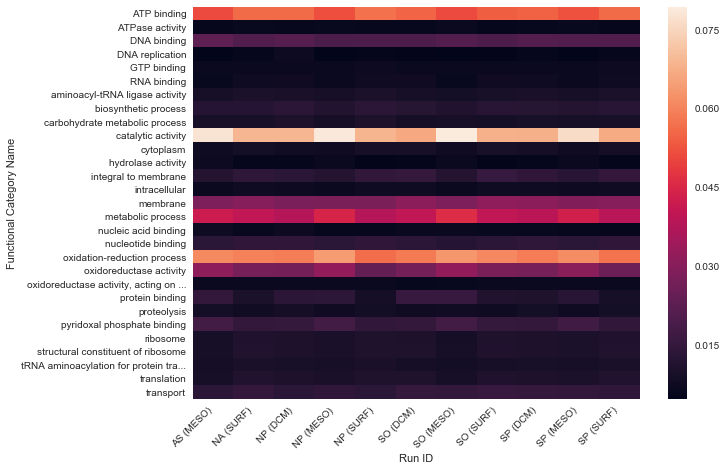

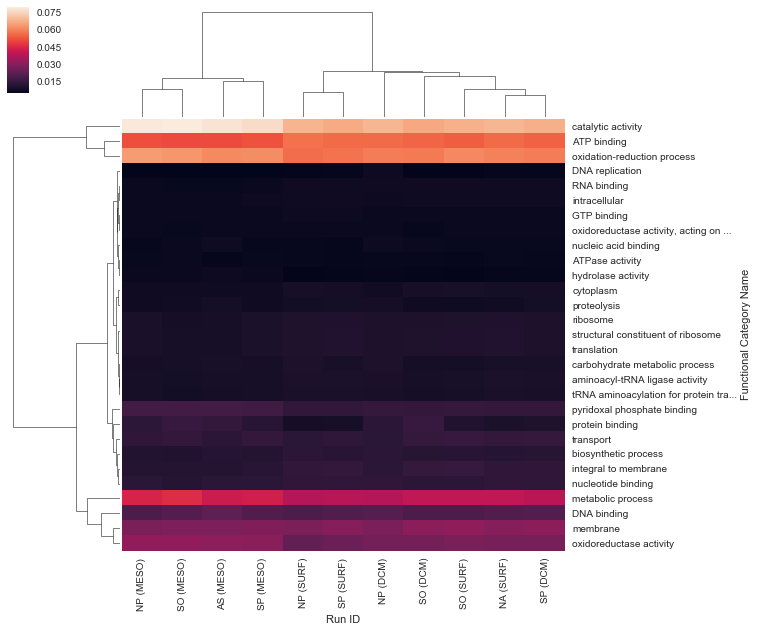

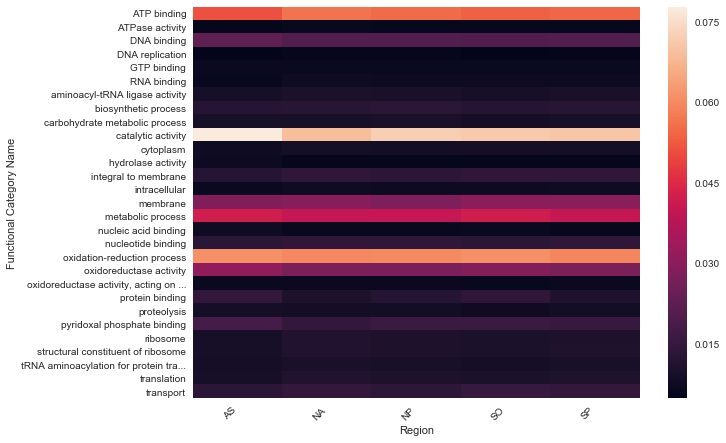

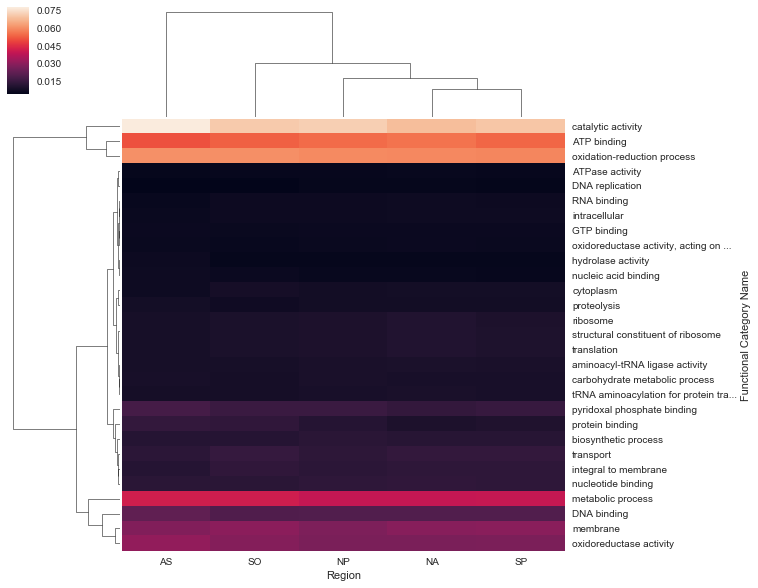

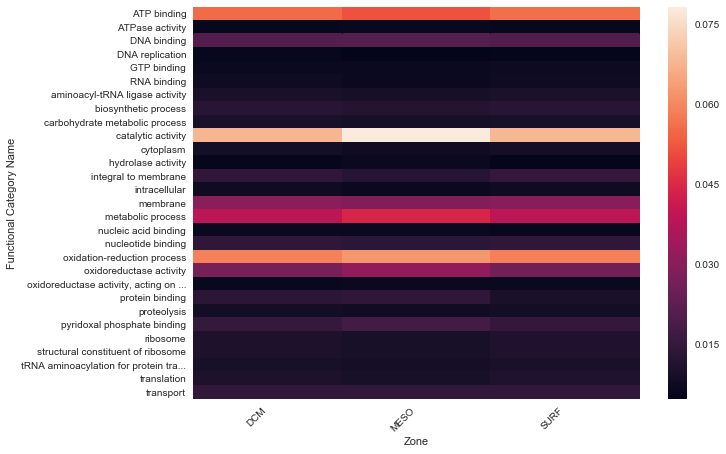

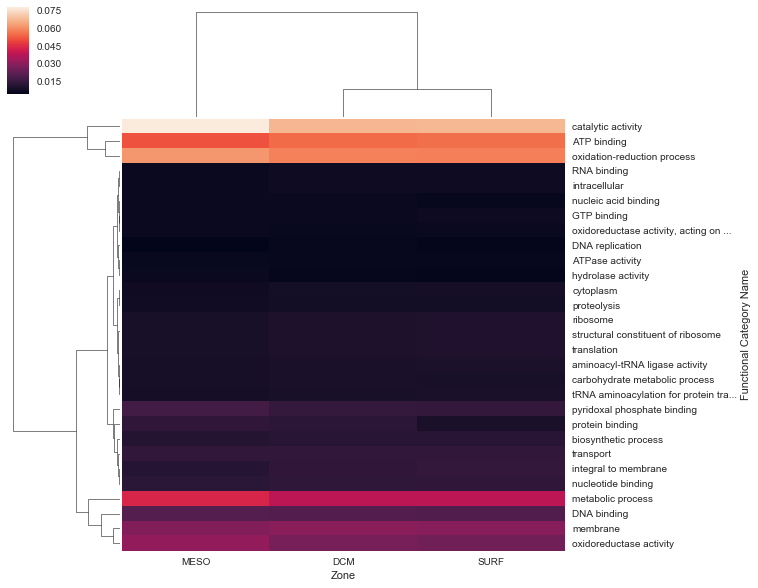

In [6]:
## Rearrange Data

# data_all: Rearrange/clean data for all samples
go_data_all = go_df.pivot(
    index='name', columns='run_id',
    values='read_percent')
go_data_all.columns.name = 'Run ID'
go_data_all.index.name = "Functional Category Name"

# data_region: Rearrange/clean data, taking mean of regions
go_data_region = go_df.pivot_table(
    index='name', columns='region',
    aggfunc={'read_percent':'mean'})
go_data_region.columns = go_data_region.columns.droplevel(0)
go_data_region.columns.name = 'Region'
go_data_region.index.name = "Functional Category Name"

# data_zone: Rearrange/clean data, taking mean of zones
go_data_zone = go_df.pivot_table(
    index='name', columns='zone',
    aggfunc={'read_percent':'mean'})
go_data_zone.columns = go_data_zone.columns.droplevel(0)
go_data_zone.columns.name = 'Zone'
go_data_zone.index.name = "Functional Category Name"


## Make Maps

# All
make_heatmap(go_data_all, 'go/heat_go_all')
make_clustermap(go_data_all, 'go/cluster_go_all')

# By Region
make_heatmap(go_data_region, 'go/heat_go_region')
make_clustermap(go_data_region, 'go/cluster_go_region')

# By Zone
make_heatmap(go_data_zone, 'go/heat_go_zone')
make_clustermap(go_data_zone, 'go/cluster_go_zone')

### Taxonomy

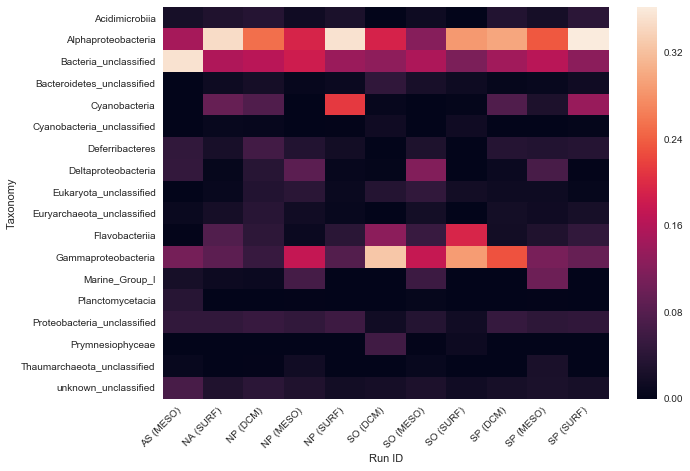

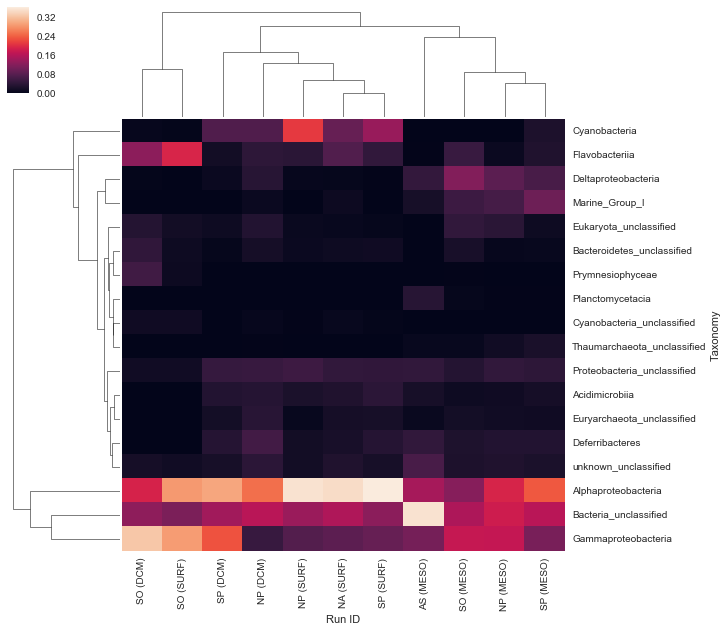

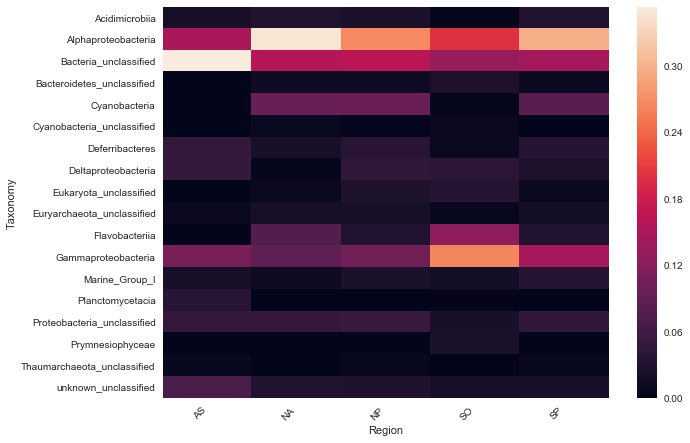

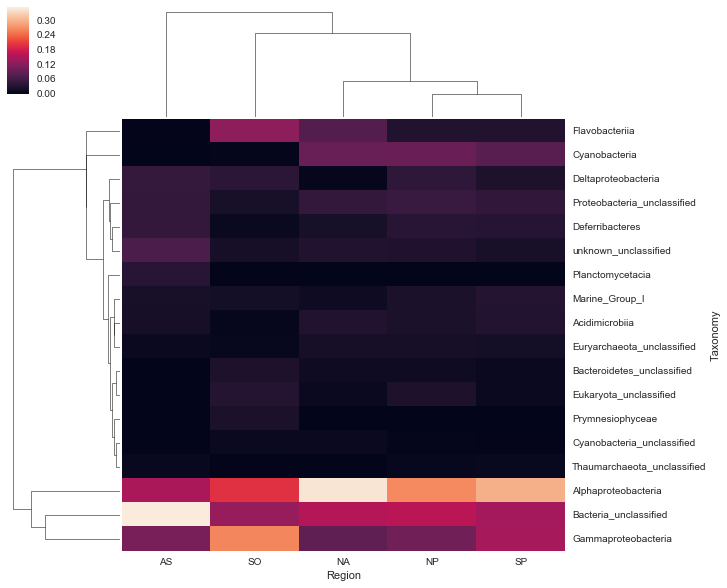

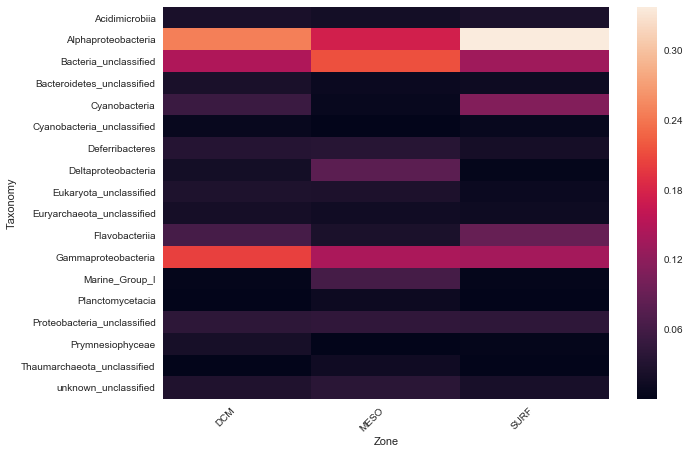

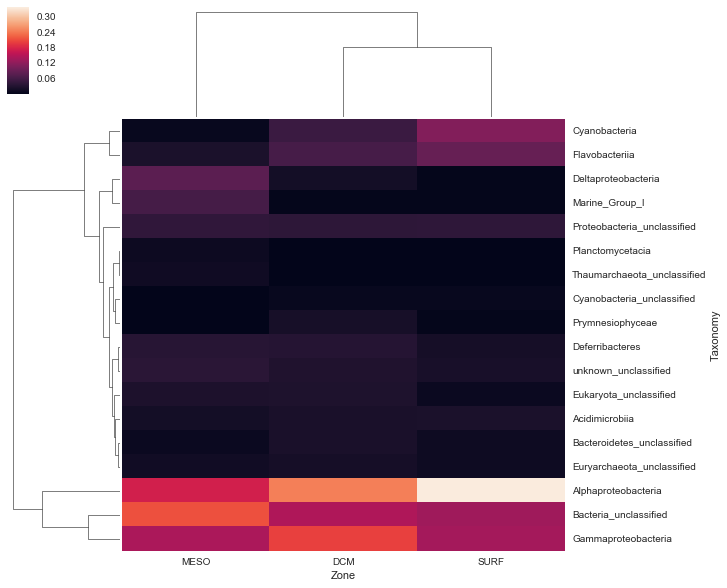

In [7]:
## Rearrange Data

# data_all: Rearrange/clean data for all samples
tax_data_all = tax_df.pivot(
    index='name', columns='run_id',
    values='tax_percent')
tax_data_all.columns.name = 'Run ID'
tax_data_all.index.name = "Taxonomy"

# data_region: Rearrange/clean data, taking mean of regions
tax_data_region = tax_df.pivot_table(
    index='name', columns='region',
    aggfunc={'tax_percent':'mean'})
tax_data_region.columns = tax_data_region.columns.droplevel(0)
tax_data_region.columns.name = 'Region'
tax_data_region.index.name = "Taxonomy"

# data_zone: Rearrange/clean data, taking mean of zones
tax_data_zone = tax_df.pivot_table(
    index='name', columns='zone',
    aggfunc={'tax_percent':'mean'})
tax_data_zone.columns = tax_data_zone.columns.droplevel(0)
tax_data_zone.columns.name = 'Zone'
tax_data_zone.index.name = "Taxonomy"


## Make Maps

lvl = f"lvl{TAXON_LVL}"

# All
make_heatmap(tax_data_all, f'tax/{lvl}/heat_tax_all')
make_clustermap(tax_data_all, f'tax/{lvl}/cluster_tax_all')

# By Region
make_heatmap(tax_data_region, f'tax/{lvl}/heat_tax_region')
make_clustermap(tax_data_region, f'tax/{lvl}/cluster_tax_region')

# By Zone
make_heatmap(tax_data_zone, f'tax/{lvl}/heat_tax_zone')
make_clustermap(tax_data_zone, f'tax/{lvl}/cluster_tax_zone')

### Heat maps, all grouped together

### Go

/Users/dustymichels/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


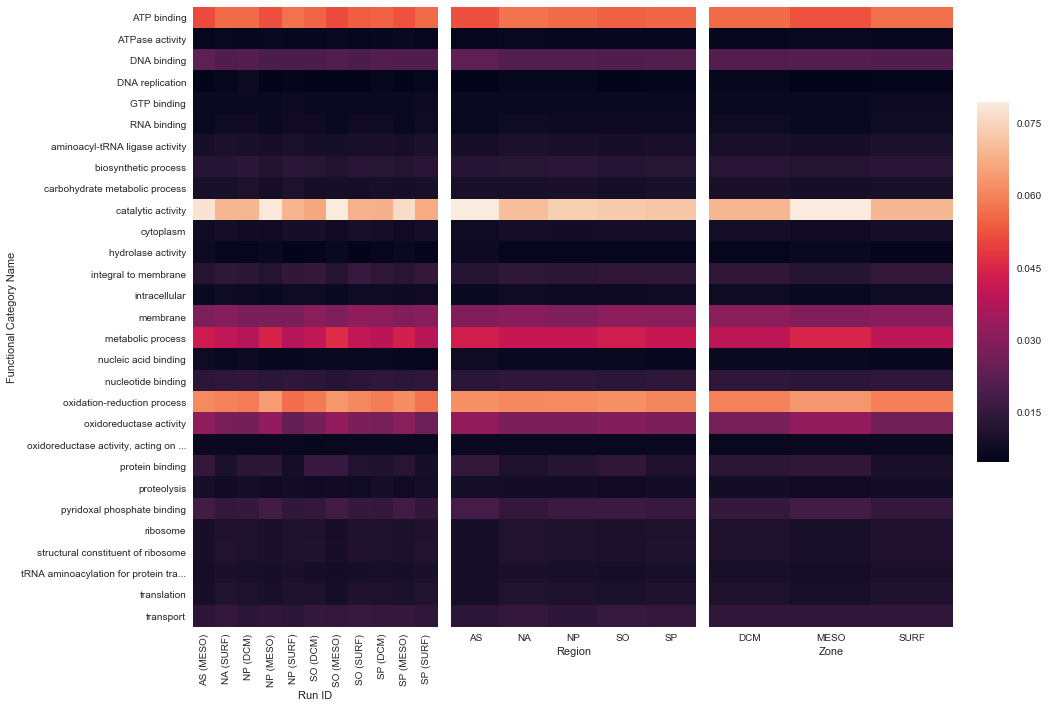

In [8]:
## Drop some labels

# data_all
go_data_all.index.name = "Functional Category Name"

# data_region
go_data_region.columns.name = 'Region'
go_data_region.index.name = None

# data_zone
go_data_zone.columns.name = 'Zone'
go_data_zone.index.name = None


## Make sublots

fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, sharey=True, figsize=(15,10))

cbar_ax = fig.add_axes([.91, .35, .03, .5])

sns.heatmap(ax=ax1, data=go_data_all, cbar_ax=cbar_ax)
sns.heatmap(ax=ax2, data=go_data_region, cbar=None)
sns.heatmap(ax=ax3, data=go_data_zone, cbar=None)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(
    f'{img_path}/heat/go/heat_go_group.png',
    bbox_inches='tight', dpi=300)

### Taxonomy

/Users/dustymichels/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


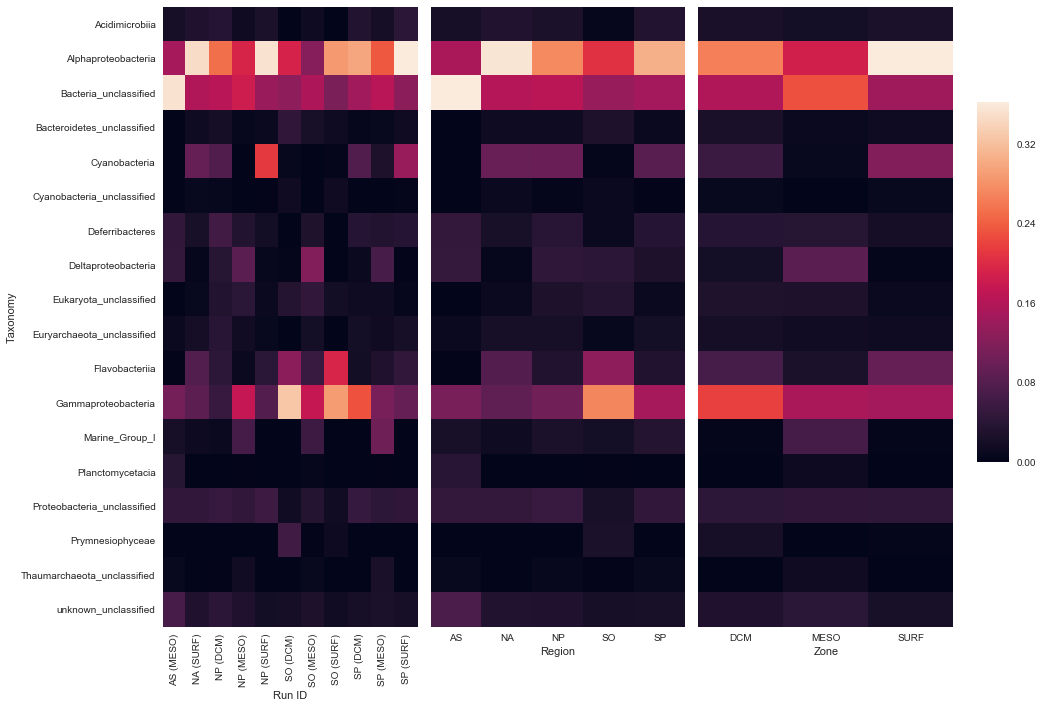

In [9]:
## Drop some labels

# data_all
tax_data_all.index.name = "Taxonomy"

# data_region
tax_data_region.columns.name = 'Region'
tax_data_region.index.name = None

# data_zone
tax_data_zone.columns.name = 'Zone'
tax_data_zone.index.name = None


## Make sublots

fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, sharey=True, figsize=(15,10))

cbar_ax = fig.add_axes([.91, .35, .03, .5])

sns.heatmap(ax=ax1, data=tax_data_all, cbar_ax=cbar_ax)
sns.heatmap(ax=ax2, data=tax_data_region, cbar=None)
sns.heatmap(ax=ax3, data=tax_data_zone, cbar=None)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(
    f'{img_path}/heat/tax/{lvl}/heat_tax_group.png',
    bbox_inches='tight', dpi=300)